# Introduction:
In this notebook, we'll explore an image recognition task using Convolutional Neural Networks (CNNs). Specifically, we aim to identify and classify objects within images. The dataset comprises images of various objects along with their annotations. We'll preprocess the images, design a CNN model, train it, and evaluate its performance on the test data.

# 1. Environment Setup

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical


# 2. Data Retrieval

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/My Drive/13659848_Junghyun_Shin_A2_Kaggle.zip"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Annotations/Oriented Bounding Boxes/3416.xml  
  inflating: Annotations/Oriented Bounding Boxes/3417.xml  
  inflating: Annotations/Oriented Bounding Boxes/3418.xml  
  inflating: Annotations/Oriented Bounding Boxes/3419.xml  
  inflating: Annotations/Oriented Bounding Boxes/342.xml  
  inflating: Annotations/Oriented Bounding Boxes/3420.xml  
  inflating: Annotations/Oriented Bounding Boxes/3421.xml  
  inflating: Annotations/Oriented Bounding Boxes/3422.xml  
  inflating: Annotations/Oriented Bounding Boxes/3423.xml  
  inflating: Annotations/Oriented Bounding Boxes/3424.xml  
  inflating: Annotations/Oriented Bounding Boxes/3425.xml  
  inflating: Annotations/Oriented Bounding Boxes/3426.xml  
  inflating: Annotations/Oriented Bounding Boxes/3427.xml  
  inflating: Annotations/Oriented Bounding Boxes/3428.xml  
  inflating: Annotations/Oriented Bounding Boxes/3429.xml  
  inflating: Annotations/Oriented Bounding Boxes/343.xml  
  infl

# 3. Annotation Parsing



In [ ]:
# Function to read annotations from an xml file
def read_annotations(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((name, (xmin, ymin, xmax, ymax)))
    return annotations


# 4. Sample Image Visualization

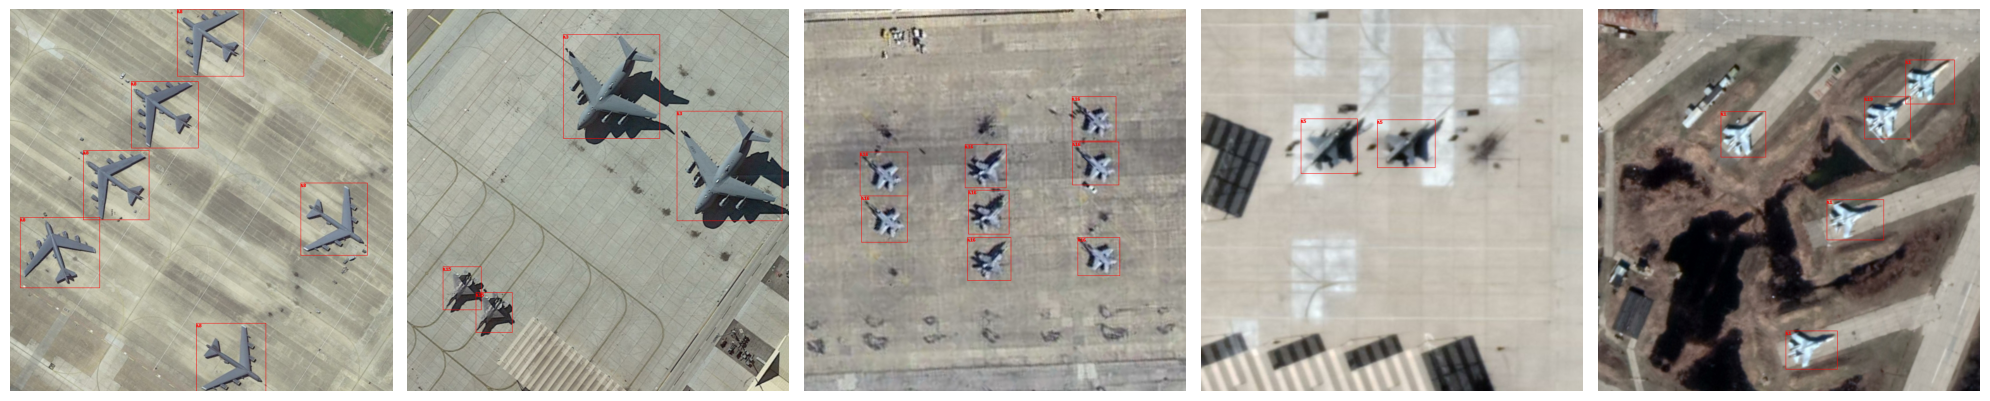

In [ ]:
def visualize_sample_images(images_path, annotations_path, num_samples=5):
    """Visualize a set number of sample images with their annotations."""
    # Load a few images and their annotations
    sample_images = os.listdir(images_path)[:num_samples]
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 20))

    for ax, img_name in zip(axes, sample_images):
        img_path = os.path.join(images_path, img_name)
        img = Image.open(img_path)

        # Load the corresponding annotation
        annotation_path = os.path.join(annotations_path, img_name.split('.')[0] + '.xml')
        annotations = read_annotations(annotation_path)

        # Draw bounding boxes on the image
        draw = ImageDraw.Draw(img)
        for label, (xmin, ymin, xmax, ymax) in annotations:
            draw.rectangle([(xmin, ymin), (xmax, ymax)], outline='red')
            draw.text((xmin, ymin), label, fill='red')

        # Display the image with bounding boxes
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Define the paths
base_path = '/content'
images_path = os.path.join(base_path, 'JPEGImages')
annotations_path = os.path.join(base_path, 'Annotations', 'Horizontal Bounding Boxes')

# Call the function to visualize sample images
visualize_sample_images(images_path, annotations_path)


# 5. Data Preprocessing

In [ ]:
# Paths
base_path = '/content'
images_path = os.path.join(base_path, 'JPEGImages')
annotations_path = os.path.join(base_path, 'Annotations', 'Horizontal Bounding Boxes')

# List to store all data and labels
all_data = []
all_labels = []

# Define an image size for resizing
IMG_SIZE = (224, 224)

# Process each image
for img_name in os.listdir(images_path):
    img_path = os.path.join(images_path, img_name)
    annotation_path = os.path.join(annotations_path, img_name.split('.')[0] + '.xml')

    # Open the image
    img = Image.open(img_path).convert("RGB")  # Ensure 3 channels with convert("RGB")

    # Get bounding boxes from the XML annotation
    annotations = read_annotations(annotation_path)
    for label, bbox in annotations:
        # Crop the image using the bounding box
        cropped_img = img.crop(bbox)
        cropped_img = cropped_img.resize(IMG_SIZE)  # Resize the cropped image
        all_data.append(np.array(cropped_img))
        all_labels.append(label)

# Convert data and labels to numpy arrays
all_data = np.array(all_data)
all_labels = np.array(all_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.33, random_state=42)


# 6. CNN Model Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Create an instance of the model
input_shape = X_train[0].shape
num_classes = len(np.unique(y_train))
model = create_cnn_model(input_shape, num_classes)


# 7. Model Compilation

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 8. Label Encoding and One-Hot Encoding

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)


# 9. Model Training

In [ ]:
history = model.fit(X_train, y_train_onehot, epochs=10, validation_data=(X_test, y_test_onehot))


Epoch 1/10
468/468 [==============================] - 239s 509ms/step - loss: 27.0461 - accuracy: 0.2640 - val_loss: 2.1954 - val_accuracy: 0.3491
Epoch 2/10
468/468 [==============================] - 241s 514ms/step - loss: 1.6890 - accuracy: 0.4955 - val_loss: 2.1714 - val_accuracy: 0.3867
Epoch 3/10
468/468 [==============================] - 241s 514ms/step - loss: 1.1429 - accuracy: 0.6540 - val_loss: 2.8305 - val_accuracy: 0.3227
Epoch 4/10
468/468 [==============================] - 245s 524ms/step - loss: 0.9219 - accuracy: 0.7178 - val_loss: 2.6968 - val_accuracy: 0.4811
Epoch 5/10
468/468 [==============================] - 243s 518ms/step - loss: 0.7053 - accuracy: 0.7904 - val_loss: 3.0667 - val_accuracy: 0.4938
Epoch 6/10
468/468 [==============================] - 246s 525ms/step - loss: 0.6369 - accuracy: 0.8163 - val_loss: 3.8292 - val_accuracy: 0.4748
Epoch 7/10
468/468 [==============================] - 234s 499ms/step - loss: 0.5291 - accuracy: 0.8509 - val_loss: 3.6366 

# 10. Training Evaluation

## 10.1	Learning Curves

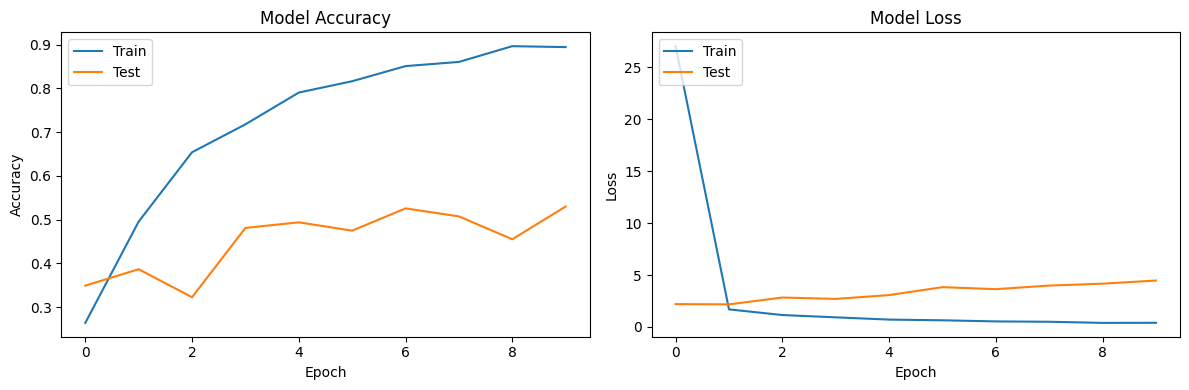

In [ ]:
# Plotting accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


## 10.2 Histogram of Prediction Probabilities

231/231 [==============================] - 17s 72ms/step


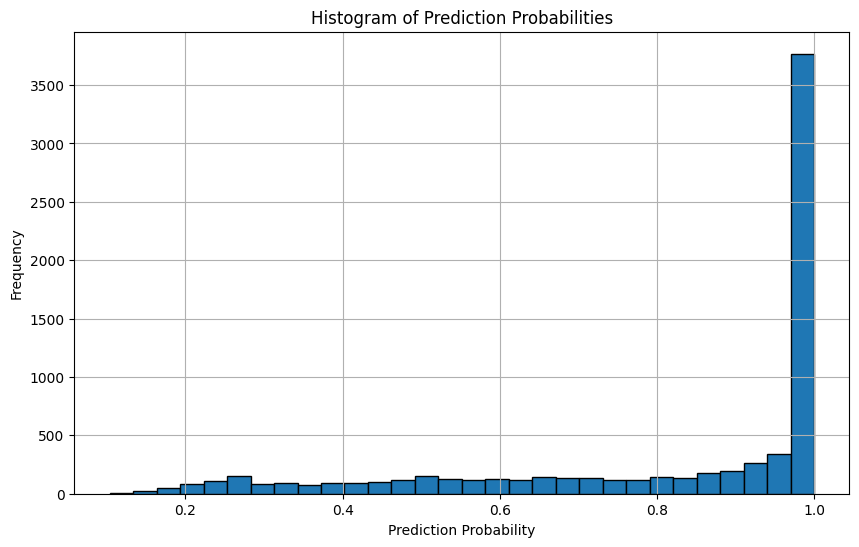

In [ ]:
# Get the prediction probabilities
prediction_probs = model.predict(X_test)

# Extract the maximum probability for each prediction
max_probs = np.max(prediction_probs, axis=1)

plt.figure(figsize=(10, 6))
plt.hist(max_probs, bins=30, edgecolor='k')
plt.title('Histogram of Prediction Probabilities')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# 11. Sample Predictions

231/231 [==============================] - 17s 74ms/step


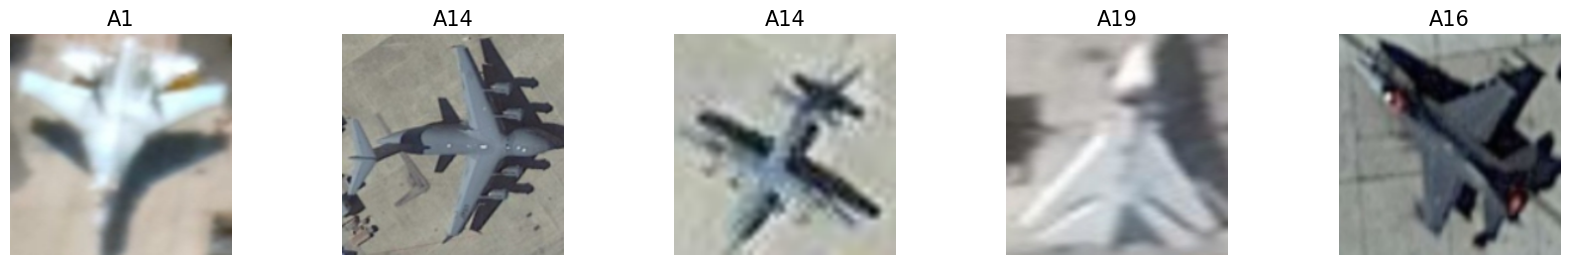

In [ ]:
predictions = model.predict(X_test)
predicted_labels = encoder.inverse_transform(np.argmax(predictions, axis=1))

# Displaying a few predictions
def plot_images(images, labels):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.ravel()
    for i in np.arange(0, 5):
        axes[i].imshow(images[i])
        axes[i].set_title(labels[i], fontsize=15)
        axes[i].axis('off')
    plt.subplots_adjust(wspace=0.5)

plot_images(X_test[:5], predicted_labels[:5])
